In [1]:
import numpy as np
from ecog_band.utils import *
import pandas as pd
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from ecog_band.datasetAllband import SVMDataset
from ecog_band.models import SVMBinClassifier
import os
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from ecog_band.utils import *
from ecog_band.solver import Nfold_solver
import pandas as pd
# from ecog_band.datasetExcludeBand import CustomDatasetExcband
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

HS = 69
freq = 500

rootPath = f'/root/pp/covert-reading/Ecog_pretrain/accuracy_results_svm_avgfreq/HS{HS}/{freq}'
path = "/public/DATA/overt_reading/"

band_list = get_all_band()
n_freq_bands = len(band_list)
idx_elec = list(range(0, 256))
# idx_elec = [0]

/root/pp/covert-reading/Ecog_pretrain/ecog_band/solver.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # may raise warning about Jupyter


In [26]:
# 所有电极在不同频段的acc
acc_dic = cal_all_elec_acc(rootPath, HS, freq)
# print(acc_dic[23])

average_acc = {band: [] for band in band_list}

# 计算每个频段的准确率
for elec in acc_dic:
    for band in band_list:
        average_acc[band].append(acc_dic[elec][band])

# 计算每个频段的平均准确率
mean_acc = {band: np.mean(accuracies) for band, accuracies in average_acc.items()}

print("Mean accuracies for each frequency band:")
for band, acc in mean_acc.items():
    print(f"Band {band}: {acc:.2f}")


Mean accuracies for each frequency band:
Band else1: 0.77
Band delta: 0.74
Band theta: 0.74
Band alpha: 0.74
Band beta: 0.73
Band gamma: 0.73
Band high gamma: 0.73
Band else2: 0.77


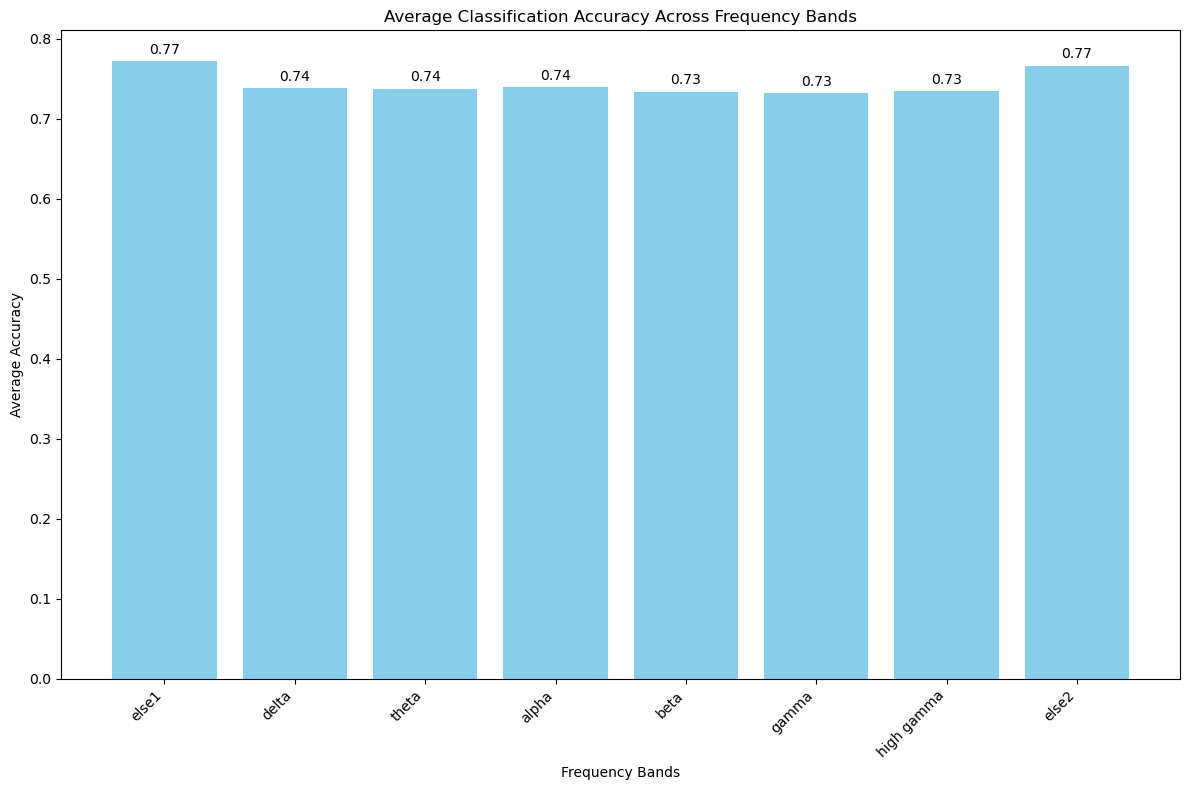

In [9]:
import matplotlib.pyplot as plt

# 提取数据
bands = list(mean_acc.keys())
mean_values = list(mean_acc.values())

# 绘制条形图
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(bands, mean_values, color='skyblue')

# 添加标题和标签
ax.set_xlabel('Frequency Bands')
ax.set_ylabel('Average Accuracy')
ax.set_title('Average Classification Accuracy Across Frequency Bands')
ax.set_xticks(bands)
ax.set_xticklabels(bands, rotation=45, ha='right')

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f"/root/pp/covert-reading/Ecog_pretrain/figures/fig_bandacc_comparison_HS{HS}.pdf", dpi=1200)
plt.show()


In [20]:
contribution_dic = {}
for elec in idx_elec:
    contribution_save_path = f'/root/pp/covert-reading/Ecog_pretrain/contribution_results_svm_avgfreq/HS{HS}/{freq}/{elec}'
    contribution_list = np.load(os.path.join(contribution_save_path, f'contributions.npy'))
    contribution_dic[elec] = contribution_list
print(contribution_dic[123])

contribution_band = {}
for id, band in enumerate(band_list):
    for elec in idx_elec:
        contribution_band[band] = contribution_dic[elec][id]
        
mean_contri = {band: np.mean(contri) for band, contri in contribution_band.items()}

print("Mean contribution for each frequency band:")
for band, contribution in mean_contri.items():
    print(f"Band {band}: {contribution:.2f}")

[ 0.03333333  0.          0.         -0.01666667 -0.01666667  0.03333333
  0.          0.        ]
Mean contribution for each frequency band:
Band else1: 0.00
Band delta: 0.00
Band theta: 0.00
Band alpha: 0.00
Band beta: 0.00
Band gamma: 0.00
Band high gamma: 0.00
Band else2: 0.01


In [27]:
# 计算每个频段在256个电极上的平均Recall和Specificity
cm_dic = cal_all_elec_cm(rootPath, HS, freq)

average_recall = {band: [] for band in band_list}
average_speci = {band: [] for band in band_list}

for band in band_list:
    for elec in range(256):
        cm_band = cm_dic[elec][band]
        tn, fp, fn, tp = cm_band.ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        average_recall[band].append(recall)
        average_speci[band].append(specificity)
mean_recall = {band: np.mean(recall) for band, recall in average_recall.items()}
mean_speci = {band: np.mean(speci) for band, speci in average_speci.items()}
print(mean_recall)
print(mean_speci)

{'else1': 0.8411458333333335, 'delta': 0.8318780637254903, 'theta': 0.831341911764706, 'alpha': 0.8315716911764706, 'beta': 0.8313419117647058, 'gamma': 0.8331801470588236, 'high gamma': 0.8347886029411765, 'else2': 0.8349417892156863}
{'else1': 0.7212409420289856, 'delta': 0.6696671195652173, 'theta': 0.6688745471014492, 'alpha': 0.6723845108695652, 'beta': 0.6625339673913044, 'gamma': 0.6572690217391304, 'high gamma': 0.6602128623188405, 'else2': 0.7163156702898551}


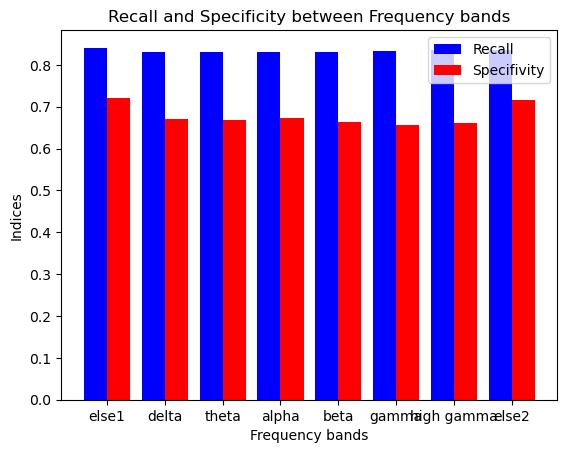

In [30]:
# 绘制柱状图
x = range(len(band_list))
plt.bar(x, mean_recall.values(), width=0.4, label='Recall', color='b', align='center')
plt.bar([p + 0.4 for p in x], mean_speci.values(), width=0.4, label='Specifivity', color='r', align='center')
plt.xlabel('Frequency bands')
plt.ylabel('Indices')
plt.xticks([p + 0.2 for p in x], band_list)
plt.legend()
plt.title('Recall and Specificity between Frequency bands')
plt.show()